In [7]:
import os
import sys 
os.chdir("/workspaces/dev/modules")
sys.path.append("/workspaces/dev/models/R-CNN")
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=2 --tf_xla_cpu_global_jit=false"
os.environ["XLA_FLAGS"] = "--xla_cpu_multi_thread_eigen=false intra_op_parallelism_threads=1 inter_op_parallelism_threads=1"

In [8]:
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [9]:
from Pills.GenerativeSequence import GenerativeSequence
from PillNet import PillNet

In [10]:
SOURCE_PATH = '/workspaces/dev/datasets/pills/data'
LABEL_PATH = '/workspaces/dev/datasets/pills/class_label.csv'
BACKGROUND_IMAGEES_PATH = '/workspaces/dev/data'

In [11]:
TRAIN_DATA_SIZE = 100000
BATCH_SIZE = 1
INPUT_SIZE = (256, 256, 3)

In [12]:
model = keras.models.load_model("/workspaces/dev/models/R-CNN/checkpoints/pill_net_2025_03_14.keras", custom_objects={'PillNet': PillNet})
model.compile_option(jit_compile=False)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
I0000 00:00:1741975281.538214   32843 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13512 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9


In [13]:
generative_sequence = GenerativeSequence(
  TRAIN_DATA_SIZE, BATCH_SIZE, input_size=INPUT_SIZE[:2], material_path=SOURCE_PATH, label_path=LABEL_PATH,
  background_images_path=BACKGROUND_IMAGEES_PATH, use_multiprocessing=True, workers=12)

In [14]:
def visualize(views):
  height = len(views)
  width = len(views[0])
  fig, axes = plt.subplots(height, width, figsize=(width*5, height*5), squeeze=False)

  for row, view in enumerate(views):
    for col, (img, title) in enumerate(view):
      axes[row][col].imshow(img)
      axes[row][col].set_title(title)
      axes[row][col].axis('off')

  plt.show()

In [15]:
def draw_label_box(img, ly, lx, ry, rx, text, color=(0, 255, 0), thickness=1):
  cv2.rectangle(img, (lx, ly), (rx, ry), color, thickness)

  text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
  if ly - text_size[1] - 5 < 0:
    text_x, text_y = lx, ry + text_size[1]
    background_lx, background_ly = lx, ry
    background_rx, background_ry = rx, ry + text_size[1] + 5
  else:
    text_x, text_y = lx, ly - text_size[1]//2
    background_lx, background_ly = lx, ly - text_size[1] - 5
    background_rx, background_ry = rx, ly
    
  cv2.rectangle(img, (background_lx, background_ly), (background_rx, background_ry), color, -1)
  cv2.putText(img, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 0), thickness, cv2.LINE_AA)

In [16]:
def draw_y(
  img:np.ndarray, 
  img_width:int, 
  img_height:int, 
  grid_size:int,
  row:int,
  col:int,
  y:list[list],
  color:tuple[int] = (0, 255, 0)
):
  grid_height = img_height // grid_size
  grid_width = img_width // grid_size
  y_min = row * grid_height
  x_min = col * grid_width

  cv2.circle(
    img, (
      int((y[0][1] * 2 - 1) * img_width + x_min), 
      int((y[0][0] * 2 - 1) * img_height + y_min)
    ), 3, color, -1
  )
  
  ly = int(((y[1][0]*2 - 1) * img_height) + y_min)
  lx = int(((y[1][1]*2 - 1) * img_width) + x_min)
  ry = int(((y[1][2]*2 - 1) * img_height) + y_min)
  rx = int(((y[1][3]*2 - 1) * img_width) + x_min)

  if ly < 0:
    ly = 0
  elif ly > img_height - 1:
    ly = img_height - 1
  if lx < 0:
    lx = 0
  elif lx > img_width - 1:
    lx = img_width - 1

  if ry > img_height:
    ry = img_height
  elif ry <= ly:
    ry = ly+1
  if rx > img_width:  
    rx = img_width
  elif rx <= lx:
    rx = lx+1

  draw_label_box(img, ly, lx, ry, rx, f'{generative_sequence.get_label(np.argmax(y[3]))}', color=color)

  if y[2].dtype != np.bool_:
    mask = (y[2] > 0.5).astype(np.uint8)
  else:
    mask = y[2].astype(np.uint8)
  mask = cv2.resize(mask, (rx-lx, ry-ly), cv2.INTER_NEAREST)
  overlay = np.dstack([mask, mask, mask])
  overlay[mask > 0] = color
  img[ly:ry, lx:rx][mask > 0] = img[ly:ry, lx:rx][mask > 0] * 0.9 + overlay[mask > 0] * 0.1
  return img

In [17]:
idx = 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


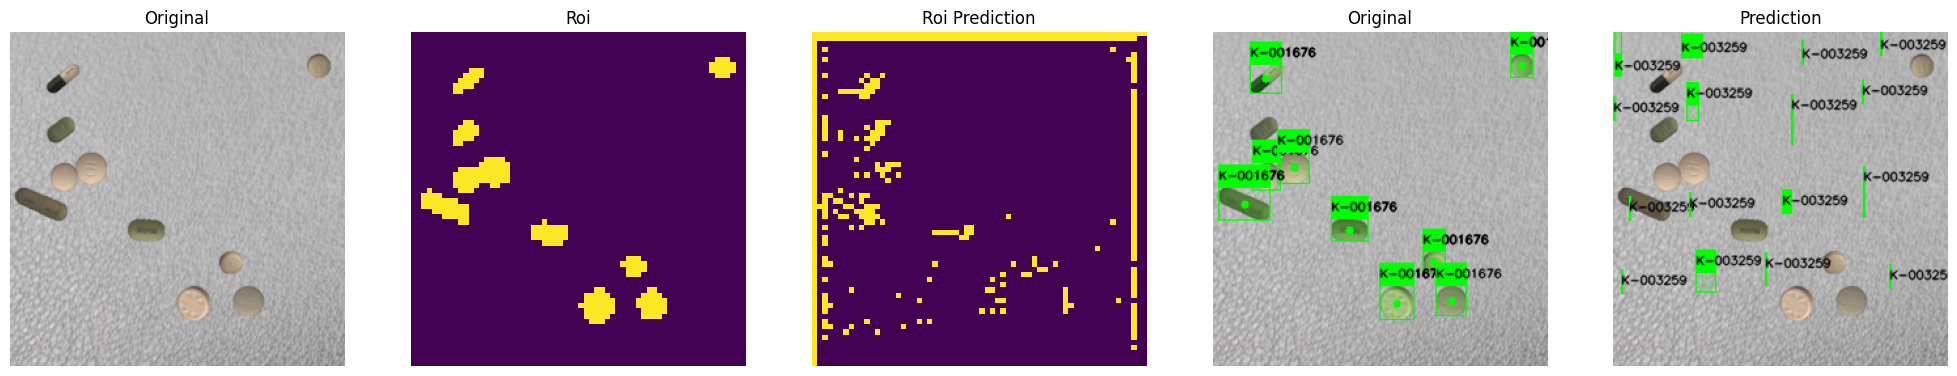

In [25]:
X, y = generative_sequence[idx]
pred_y = model.predict(X)

idx += 1
grid_size = model.grid_size
z = zip(
  X, zip(y["roi"], y["centroid"], y["detection"], y["segmentation"], y["classification"]),
  zip(pred_y["roi"], pred_y["centroid"], pred_y["detection"], pred_y["segmentation"], pred_y["classification"])
)

for img, y_true, y_pred in z:
  img_height = img.shape[0]
  img_width = img.shape[1]
  view_lines = []

  roi = y_true[0].astype(np.uint8) * 255
  pred_roi = (y_pred[0] > 0.5).astype(np.uint8) * 255
  img = (img * 255).astype(np.uint8)
  view = [(img, "Original"), (roi, "Roi"), (pred_roi, "Roi Prediction")]

  original_img = img.copy()
  pred_img = img.copy()

  y = zip(zip(y_true[1], y_true[2], y_true[3], y_true[4]), zip(y_pred[1], y_pred[2], y_pred[3], y_pred[4]))
  for row, (y_true, y_pred) in enumerate(y):
    y = zip(zip(y_true[0], y_true[1], y_true[2], y_true[3]), zip(y_pred[0], y_pred[1], y_pred[2], y_pred[3]))
    for col, (y_true, y_pred) in enumerate(y):
      original_img = draw_y(original_img, img_width, img_height, grid_size, row, col, y_true)
      pred_img = draw_y(pred_img, img_width, img_height, grid_size, row, col, y_pred)

  view.append((original_img, "Original"))
  view.append((pred_img, "Prediction"))
  view_lines.append(view)

visualize(view_lines)

In [19]:
raise Exception("End")

Exception: End

In [ ]:
real_img = cv2.imread("/workspaces/dev/models/R-CNN/0.jpg")
real_img = cv2.resize(real_img, (128, 128))

img_hsv = cv2.cvtColor(real_img, cv2.COLOR_BGR2HSV)
# (OpenCV에서) HSV: H∈[0,179], S∈[0,255], V∈[0,255]

# 3) 채도(S) & 노출(밝기, V) 높이기
img_hsv = img_hsv.astype(np.float32)

s_factor = 2.0  # 채도 2배
v_factor = 1.5  # 밝기(노출) 1.5배

img_hsv[..., 1] = np.clip(img_hsv[..., 1] * s_factor, 0, 255)
img_hsv[..., 2] = np.clip(img_hsv[..., 2] * v_factor, 0, 255)

# 4) HSV -> BGR 복귀
img_hsv = img_hsv.astype(np.uint8)
high_sat_exp_img = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)

# 5) 필요하다면 float 형으로 [0,1] 범위로 변환
real_img = high_sat_exp_img.astype(np.float32) / 255.0


[ WARN:0@940.150] global loadsave.cpp:268 findDecoder imread_('/workspaces/dev/models/R-CNN/0.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


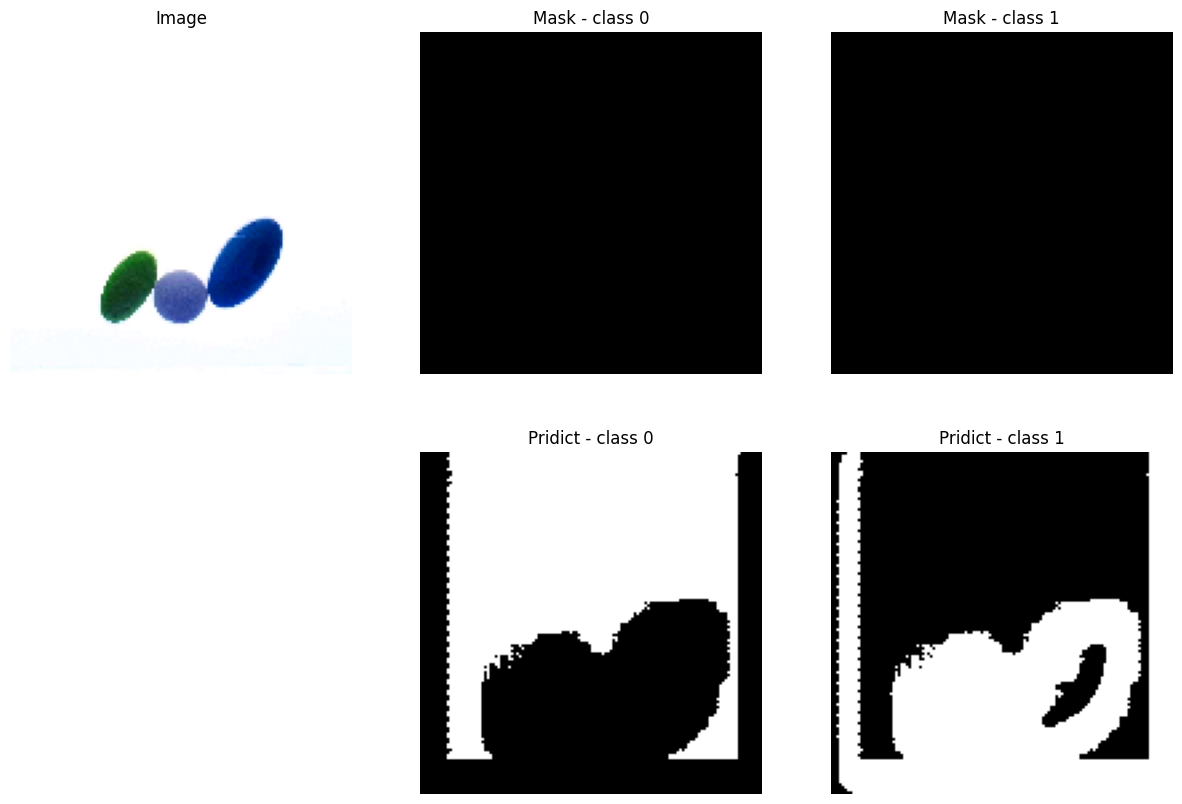

In [ ]:
p_y = model.predict(np.array([real_img]))
visualize_mask(real_img, p_y[0], p_y[0])

In [ ]:
def generate_background(color:tuple[int] = None, size:tuple[int] = (128, 128, 3)):
  if color is None:
    color = np.random.randint(0, 255, 3)
  color = color/255
  background = np.empty(size, dtype=np.float64)
  background[:, :] = color
  return background

In [ ]:
def merge_object_with_background(object_img:np.ndarray, background:np.ndarray):
  background = background.copy()
  mask = object_img <= 0
  merged = np.where(mask, background, object_img)

  return merged

In [ ]:
def show(img):
  plt.figure(figsize=(10, 10))
  plt.imshow(img)
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


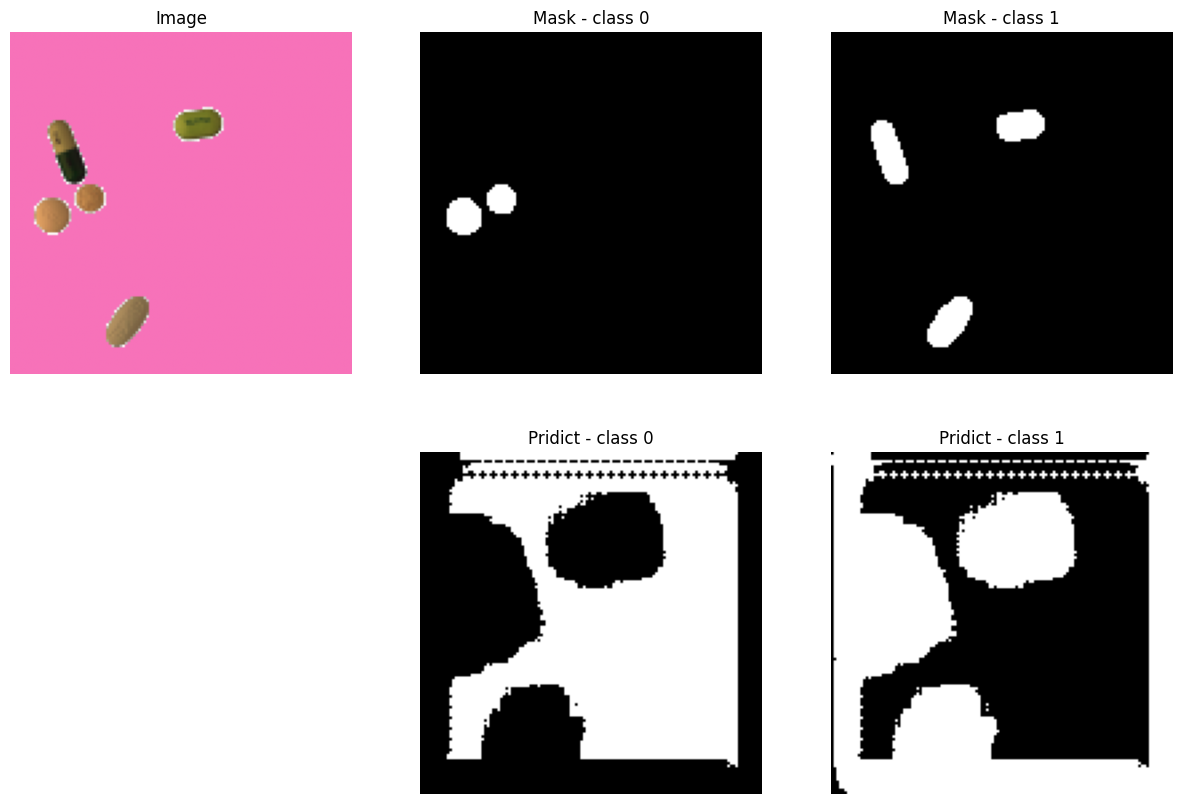

In [ ]:
background_train, target = test_sequence[np.random.randint(len(test_sequence))]
background_train = background_train[0]
target = target[0]
background = generate_background()
merged = merge_object_with_background(background_train, background)
p_y = model.predict(np.array([merged]))
visualize_mask(merged, target, p_y[0])